In [1]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import os

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict
import datetime
import sys

## Include IoT Grabber
try:
    from iot_grabber import IotGrabber
    print("Import in cwd")
except:
    sys.path.append('../../iot_grabber')
    from iot_grabber import IotGrabber

## Include toolkittry:
try:
    from rmse import calc_rmse
    from sine_fitting import SineFitting
    print("Import in cwd")
except:
    sys.path.append('../../prediction/toolkit')
    from rmse import calc_rmse
    from sine_fitting import SineFitting


#include ../../iot-grabber.iot-grabber

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()


In [2]:
sys.path

['x:\\git\\LRZ\\masters-thesis\\pytorch\\sine-fitting',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\DLLs',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310',
 '',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\BeneDesktop\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\Pythonwin',
 '../../iot_grabber',
 '../../prediction/toolkit']

+--------------------------+------------------------------------------------+
|          Field           |                     Value                      |
+--------------------------+------------------------------------------------+
|            IP            |                100.113.141.113                 |
|         Devices          |            ['INV2', 'TEMP', 'HUM']             |
|    Time absolut start    |              2024-08-24T00:00:00Z              |
|     Time absolut end     |              2024-08-25T00:00:00Z              |
|        Time range        |                      None                      |
|     Time resolution      |                       1m                       |
|   Prediction horizont    |                       15                       |
| Prediction horizont unit |                      min                       |
|        Delimiter         |                       ;                        |
|           CWD            | x:\git\LRZ\masters-thesis\pytorch\s

<AxesSubplot: xlabel='Date'>

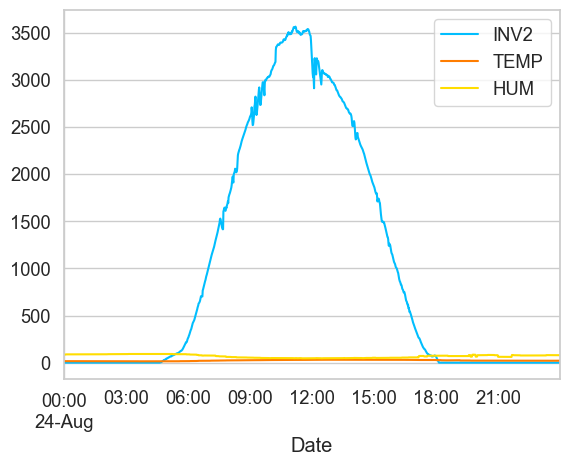

In [3]:
# Load df directly from IoT Server --> only working within the Tailscale VPN connection
ip = "100.113.141.113"
devices = ["INV2", "TEMP", "HUM"] # First device defines the value to be forecasted
time_abs_start = "2024-08-24T00:00:00Z"
time_abs_end   = "2024-08-25T00:00:00Z"
time_range = "None"
res = "1m"

iot_server = IotGrabber(
                          ip=ip,
                          devices=devices,
                          time_abs_start=time_abs_start,
                          time_abs_end=time_abs_end,
                          range=time_range,
                          res=res,
                          delimiter=";",
                          cwd=os.getcwd()
                          )
iot_server.setRange(time_range)

print(iot_server)
df = iot_server.get_df()

print(df)

df.plot()

72.20372510098524


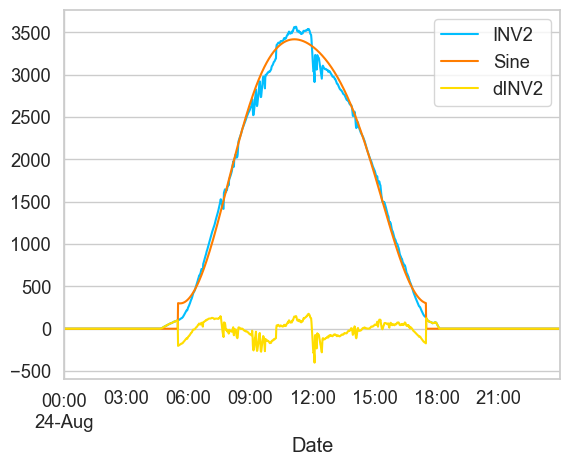

In [13]:

def signal_fft(signal, num_frequencies):
    N = len(signal)  # Length of the input signal
    x_vals = np.linspace(0, 1, N)  # Input domain in [0, 1]

    # Step 1: FFT on the signal
    X = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N)  # Frequency bins

    # Step 2: Get magnitudes and select the top k frequencies
    magnitudes = np.abs(X)
    indices = np.argsort(magnitudes)[-num_frequencies:]  # Indices of the top k frequencies

    # Extract the important frequencies, amplitudes, and phases
    top_freqs = freqs[indices]  # Frequencies of the top k components
    top_amplitudes = np.abs(X[indices])  # Amplitudes of the top k components
    top_phases = np.angle(X[indices])  # Phases of the top k components
    return top_freqs, top_amplitudes, top_phases


def reconstruction_func(x, top_freqs, top_amplitudes, top_phases, signal_length, scaling=1):
    # Ensure x is a numpy array for vectorized operations
    x = np.asarray(x)

    # Initialize the reconstructed signal
    reconstructed = np.zeros_like(x, dtype=float)

    # Rebuild the signal using the top k frequencies
    for freq, amp, phase in zip(top_freqs, top_amplitudes, top_phases):
        # Construct each component: A * cos(2π * f * x * N + phase)
        reconstructed += amp * np.cos(2 * np.pi * freq * x * signal_length + phase)

    return reconstructed * scaling


def basis_function(t_min, sunrise_min, sunset_min, top_freqs, top_amplitudes, top_phases, signal_length, scaling=1):


    t_wave_input = (t_min - sunrise_min) / (sunset_min - sunrise_min)

    reconstructed = reconstruction_func(t_wave_input, top_freqs, top_amplitudes, top_phases, signal_length) * scaling


    reconstructed[(t_min < sunrise_min) | (t_min > sunset_min)] = 0

    return reconstructed


# fit the function
# Parameters for fitting the function
sunrise_min = 5.5
sunset_min = 17.5
num_frequencies = 5

length_of_INV2 = len(df.INV2.values)
x = df.INV2.values
x = x[int(sunrise_min * 60) : int(sunset_min * 60)] # cut only the sine-parts of the waveform
top_freqs, top_amplitudes, top_phases = signal_fft(x / x.max(), num_frequencies)
signal_length = x.shape[0]
scaling = 5

xi = np.linspace(0, 24 * 60, length_of_INV2)
INV2_modeled = basis_function(xi, 5.5 * 60, 17.5 * 60, top_freqs, top_amplitudes, top_phases, signal_length=signal_length, scaling=scaling)

# Calc difference between the measurement and the modeled sine waveform
dINV2 = df.INV2.values - INV2_modeled

df_computed = pd.DataFrame()
df_computed.insert(0, "Date", df.index.values)
df_computed.insert(1, "INV2", df.INV2.values)
df_computed.insert(2, "Sine", INV2_modeled)
df_computed.insert(3, "dINV2", dINV2)
df_computed.set_index("Date")

# Calc RMSE value
rmse_sine = calc_rmse(df_computed.INV2, df_computed.Sine)

# Plot
df_computed.plot(x=0)
print(rmse_sine)



In [4]:
len(df.index)

1440

72.20372510098524


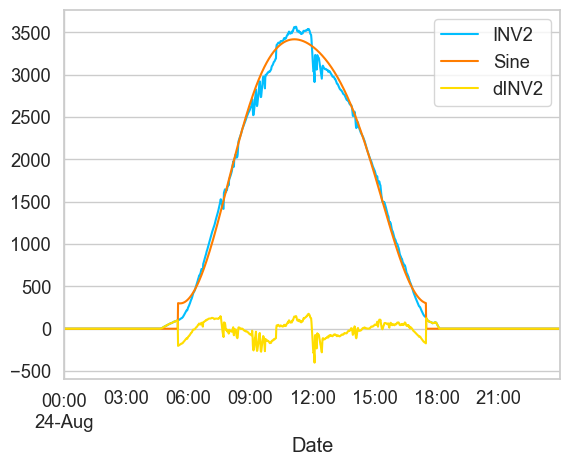

In [4]:
sine_fitting = SineFitting(sunrise_min=5.5, sunrise_max=17.5) 
sine_fitting.set_previous_day(df)

INV2_modeled = sine_fitting.calc_sine()
dINV2 = sine_fitting.calc_d()

# Sum everything in a pandas df
df_computed = pd.DataFrame()
df_computed.insert(0, "Date", df.index.values)
df_computed.insert(1, "INV2", df.INV2.values)
df_computed.insert(2, "Sine", INV2_modeled)
df_computed.insert(3, "dINV2", dINV2)
df_computed.set_index("Date")

# Calc RMSE value
rmse_sine = calc_rmse(df_computed.INV2, df_computed.Sine)

# Plot
df_computed.plot(x=0)
print(rmse_sine)


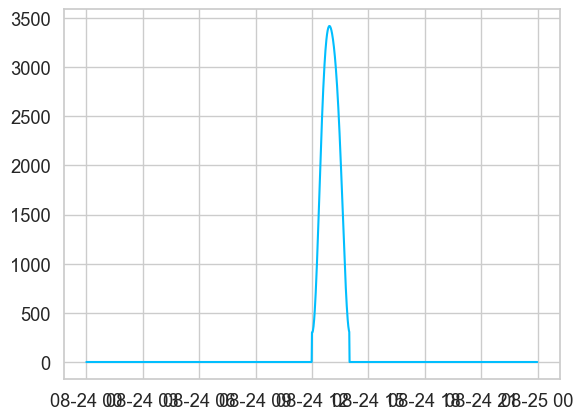

In [16]:
fig, ax = plt.subplots()


ax.plot(
    df.index,
    INV2_modeled
)

# ax.plot(
#     df.index,
#     df.INV2.values
# )

# ax.plot(
#     df.index,
#     dINV2
# )



# ax.plot(
#     np.linspace(0, 24 * 60, df.INV2.values.shape[0]),
#     df.INV2.values
# )


72.20372510098524


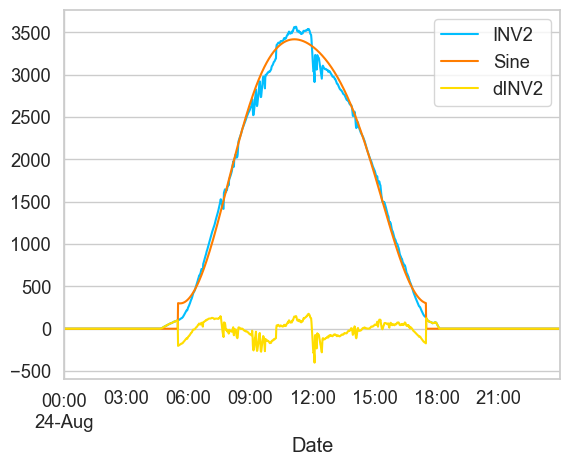

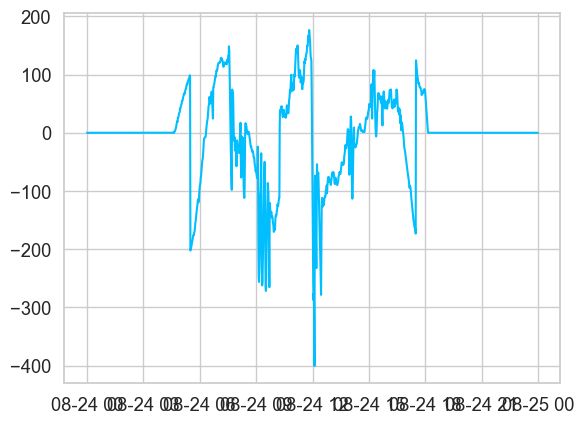

In [43]:

dINV2

fig, ax = plt.subplots()
ax.plot(
    df.index,
    dINV2
)
plt.show()

In [28]:
df.INV2.values.shape[0]

1440

In [39]:
x.shape

(720,)